In [1]:
import tarfile
import urllib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

In [3]:
jdt_df = pd.read_csv("ar3_apache.csv")
#jdt_df['class']=jdt_df['class'].map({'clean':1,'buggy':0})
print(jdt_df.info())
X = jdt_df.iloc[:,0:15]
#print(X.head())
True_val=jdt_df.iloc[:,15]
print(True_val.head())
#Y['class']=Y['class'].map({'clean':1,'buggy':0})

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63 entries, 0 to 62
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   AvgLine                63 non-null     float64
 1   CountLine              63 non-null     int64  
 2   CountLineBlank         63 non-null     int64  
 3   CountLineCode          63 non-null     int64  
 4   CountLineCodeDecl      63 non-null     int64  
 5   CountLineCodeExe       63 non-null     float64
 6   CountLineComment       63 non-null     int64  
 7   CountSemicolon         63 non-null     int64  
 8   CountStmt              63 non-null     float64
 9   CountStmtDecl          63 non-null     int64  
 10  CountStmtExe           63 non-null     int64  
 11  SumCyclomatic          63 non-null     float64
 12  SumCyclomaticModified  63 non-null     int64  
 13  SumCyclomaticStrict    63 non-null     int64  
 14  SumEssential           63 non-null     int64  
 15  defects 

In [5]:
label_encoder = LabelEncoder()
true_labels = label_encoder.fit_transform(True_val)
true_labels[:63]

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1],
      dtype=int64)

In [6]:
label_encoder.classes_

array([0, 1], dtype=int64)

In [7]:
n_clusters = len(label_encoder.classes_)

In [8]:
preprocessor = Pipeline(
        [
            ("scaler", MinMaxScaler()),
            ("pca", PCA(n_components=2, random_state=42)),
        ]
    )

In [9]:
clusterer = Pipeline(
       [
           (
               "kmeans",
               KMeans(
                   n_clusters=n_clusters,
                   init="k-means++",
                   n_init=50,
                   max_iter=500,
                   random_state=42,
               ),
           ),
       ]
    )

In [10]:
pipe = Pipeline(
        [
            ("preprocessor", preprocessor),
            ("clusterer", clusterer)
        ]
    )

In [11]:
pipe.fit(X)

Pipeline(memory=None,
         steps=[('preprocessor',
                 Pipeline(memory=None,
                          steps=[('scaler',
                                  MinMaxScaler(copy=True,
                                               feature_range=(0, 1))),
                                 ('pca',
                                  PCA(copy=True, iterated_power='auto',
                                      n_components=2, random_state=42,
                                      svd_solver='auto', tol=0.0,
                                      whiten=False))],
                          verbose=False)),
                ('clusterer',
                 Pipeline(memory=None,
                          steps=[('kmeans',
                                  KMeans(algorithm='auto', copy_x=True,
                                         init='k-means++', max_iter=500,
                                         n_clusters=2, n_init=50, n_jobs=None,
                                         precomp

In [12]:
preprocessed_data = pipe["preprocessor"].transform(X)

predicted_labels = pipe["clusterer"]["kmeans"].labels_
print(silhouette_score(preprocessed_data, predicted_labels))
print(predicted_labels-true_labels)

0.7031441830185576
[ 0  0  1  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  1  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0
  0  1  0  0 -1  0  0  0  0  0  0  0  0  0  0]


In [13]:
adjusted_rand_score(true_labels, predicted_labels)

0.5322679813166575

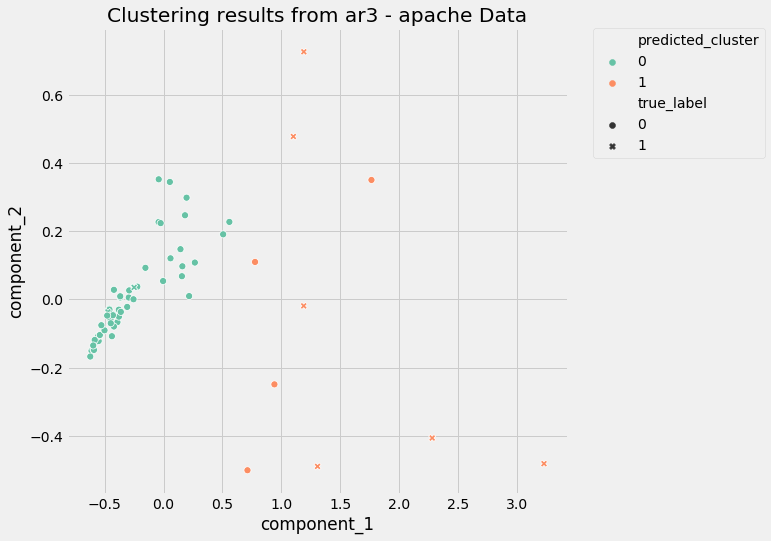

In [23]:
pcadf = pd.DataFrame(
        pipe["preprocessor"].transform(X),
        columns=["component_1", "component_2"],
    )
 
pcadf["predicted_cluster"] = pipe["clusterer"]["kmeans"].labels_
pcadf["true_label"] = label_encoder.inverse_transform(true_labels)

plt.style.use("fivethirtyeight")
plt.figure(figsize=(8, 8))

scat = sns.scatterplot(
    "component_1",
    "component_2",
    s=50,
    data=pcadf,
    hue="predicted_cluster",
    style="true_label",
    palette="Set2",
)

scat.set_title(
    "Clustering results from ar3 - apache Data"
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

plt.show()

In [18]:
#print(true_labels)
original_clean=0
original_buggy=0
j=0
while j< len(true_labels):
    #print(true_labels[j])
    if true_labels[j].size > 0:
        if true_labels[j]==1:
            original_clean+=1
    j+=1
original_buggy = len(true_labels) - original_clean
print('original_clean ', original_clean)
print('original_buggy ', original_buggy)

original_clean  8
original_buggy  55


In [19]:
#print(predicted_labels)
predicted_clean=0
predicted_buggy=0
j=0
while j <len(predicted_labels):
    #print(predicted_labels[:j])
    if predicted_labels[j].size > 0:
        if predicted_labels[j]==1:
            predicted_clean+=1
    j+=1
predicted_buggy = len(predicted_labels) - predicted_clean
print('predicted_clean ', predicted_clean)
print('predicted_buggy ', predicted_buggy)

predicted_clean  10
predicted_buggy  53


In [22]:
result=predicted_labels-true_labels
#result=result.flatten()
#print(result[10])
count=0
i=0
#print(len(result))
while i < len(result):
    if result[i]==0:
        count+=1
    i+=1
print('Accuracy ',count/len(result))

i=0
count=0
while i <len(result):
    #print(result[i])
    if result[i]==-1:
        count+=1
    i+=1
print('FN ',count)  

i=0
count=0
while i <len(result):
    #print(result[i])
    if result[i]==1:
        count+=1
    i+=1
print('FP',count) 

i=0
count=0
while i <len(result):
    #print(result[i])
    if predicted_labels[i]==0 & true_labels[i]==0:
        count+=1
    i+=1
print('TP ',count) 

i=0
count=0
while i <len(result):
    #print(result[i])
    if predicted_labels[i]==1 & true_labels[i]==1:
        count+=1
    i+=1
print('TN ',count)  

Accuracy  0.9047619047619048
FN  2
FP 4
TP  53
TN  6
